# Fractal in Logistics System

In the notebook _Fractal in Biology_, we tested the emergence of fractal from mammalian vessel system. But, the fractal is absent under the assumptions by West, et al. (1997). In this notebook, we try to update the assumptions to make them more plausible. Instead of mammalian vessel system, we consider a much simpler case: the logistic system of a city.

## Notations

- $C$: number of levels.
- $k$: level, from $0$ to $C$.
- $n_k$: number of logistics sites at $k$ level.
- $l_k$: logistics scale at $k$ level.
- $f_k$: flow rate at $k$ level.
- $\nu_k$: $n_{k+1} / n_k$.
- $\lambda_k$: $l_{k+1} / l_k$.
- $\phi_k$: $f_{k+1} / f_{k}$.

## Assumptions

Assumptions are made as follow. For details, see [this blog](https://shuiruge.github.io/2024/03/01/complex-system/) (TODO: explain the details here).

The $f_C$ and $l_C$ are fixed. Naturally, $n_0 = 1$. Thus,

$$ l_k = \frac{l_k}{l_{k+1}} \cdots \frac{l_{C-1}}{l_C} l_C = l_C \lambda_k^{-1} \cdots \lambda_{C-1}^{-1} = l_C \prod_{i=k}^{C-1} \lambda_i^{-1}. $$

The same,

$$ f_k = f_C \prod_{i=k}^{C-1} \phi_i^{-1}, $$

but,

$$ n_k = n_0 \frac{n_1}{n_0} \cdots \frac{n_k}{n_{k-1}} = \nu_0 \cdots \nu_{k-1} = \prod_{i=0}^{k-1} \nu_i. $$

The perserving of flow rate implies

$$ f_k = \nu_k^{-1}. $$

And the space-fulfilling assumption implies

$$ \lambda_k = \nu_k^{-1/2}. $$

Because of these, the unique degree of freedom is the $\nu$.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

2024-03-03 12:12:09.093671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We use several samples in searching optimal parallelly. So, the $\nu$, or for numerical stability $\ln \nu$, has tensor shape `[samples, levels]`.

In [41]:
SAMPLES = 10
LEVELS = 10

## Loss Function

The objective to be minimized is the total consumption logistics. It is

$$ F := \sum_{k=0}^C n_{k} f_{k} l_{k} = f_C l_C \sum_{k=0}^C \prod_{i=0}^{k-1} \nu_i \prod_{i=k}^{C-1} (\phi_i \lambda_i)^{-1}. $$

Plugging the relation between $\nu$ and $\phi$ and $\lambda$, we find

$$ F = f_C l_C \sum_{k=0}^C \prod_{i=0}^{k-1} \nu_i \prod_{i=k}^{C-1} \nu_i^{3/2}. $$

For numerical stability, we consider

$$ \ln F = \ln (f_C l_C) + \ln \sum_{k=0}^C \prod_{i=0}^{k-1} \nu_i \prod_{i=k}^{C-1} \nu_i^{3/2}. $$

In [42]:
def get_log_consumption(log_nu):
    """Omit the constant."""
    logits = []
    for k in range(LEVELS):
        logits.append(
            tf.reduce_sum(log_nu[:, :k], axis=1)
            + (3/2) * tf.reduce_sum(log_nu[:, k:], axis=1)
        )
    logits = tf.stack(logits, axis=1)
    return tf.reduce_logsumexp(logits, axis=1)

log_nu = np.log(2) * np.ones([1, LEVELS])
get_log_consumption(log_nu)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([11.59340619])>

The population of the city is proportional to $n_C = \prod_{k=0}^{C-1} \nu_k$. To investigate the relation between total consumption of logistics and the population of the city, the population shall be fixed.

In [43]:
def get_log_population(log_nu):
    return tf.reduce_sum(log_nu, axis=1)

get_log_population(log_nu)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([6.93147181])>

Since $n_{k+1} \ge n_k$, $\nu_k$ shall be greater than unit. So, there is another constraint that, for each $k$,

$$ \ln \nu_k \ge 0. $$

Altogether, the loss function shall be

$$ \ln F(\nu) + \mu \left( \ln n_C(\nu) - \ln \bar{n}_C \right) + \sum_{k=1}^{C-1} \omega_k \left( \ln \nu_k - z_k^2 \right), $$

for some observed values $\bar{n}_C$ given.

What is a proper value of $\bar{n}_C$. It is natural to suppose that $n_{k+1}/n_k \ge 2$. This means $\bar{n}_C$ shall be greater than the volume given by $\nu = 2$. And it shall not be too large, for numerical consideration.

In fact, it is sufficient for the optimized volume to approximate the order of $\bar{n}_C$. We can regard this optimized volume as the real $\bar{n}_C$. In other words, $\bar{n}_C$ is used to determine the order, but not the accurate value.

In [44]:
least_log_population = get_log_population(np.log(2) * np.ones([1, LEVELS]))
least_log_population

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([6.93147181])>

In [46]:
TRUE_LOG_NC = 1.5e+1

We add a configuration for forcing fractal. When forcing fractal, we use the $\ln \nu_1$ as $\ln \nu_k$ for all $k$. We can compare the final $\ln R_b$ with and without forcing fractal to see if the fractal is really a result of minimizing $\ln R_b$.

In [47]:
TEST_FORCE_FRACTAL = False

In [48]:
def get_loss(log_nu, z, mu, omega):
    if TEST_FORCE_FRACTAL:
        log_nu = log_nu[:, :1] * tf.ones_like(log_nu)

    main = get_log_consumption(log_nu)
    loss = tf.reduce_sum(main)
    constraints = []
    for multiplier, constraint in [
        (mu, get_log_population(log_nu) - TRUE_LOG_NC),
        (omega, log_nu - tf.square(z)),
        # other constraints......
    ]:
        loss += tf.reduce_sum(multiplier * constraint)
        constraints.append(constraint)
    return main, constraints, loss

z = tf.ones_like(log_nu)
get_loss(log_nu, z, 0.1, 0.1)

(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([11.59340619])>,
 [<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-8.06852819])>,
  <tf.Tensor: shape=(1, 10), dtype=float64, numpy=
  array([[-0.30685282, -0.30685282, -0.30685282, -0.30685282, -0.30685282,
          -0.30685282, -0.30685282, -0.30685282, -0.30685282, -0.30685282]])>],
 <tf.Tensor: shape=(), dtype=float64, numpy=10.479700548504006>)

## Gradient Descent with Constraints

The gradient descent algorithm with constraints is described in [Platt and Barr (1988)](https://papers.nips.cc/paper_files/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf). Briefly, descent on the parameters (the $\ln \nu$ here) and ascent on the multipliers (the $\mu$ and $\omega_k$ here). For numerical stability, it is suggested to add an $L_2$-regulation.

For example, consider scalar functions $f$ and $g$ where $f$ is lower bounded. If you want to minimize $f(x)$ with constraint $g(x) = 0$, then the loss function will be

$$ L(x, \mu) = f(x) + \mu g(x), $$

where $\mu$ is the Lagrangian multiplier. Then, optimize the $x$ along the direction

$$ \dot{x}^a = -\nabla^a L(x, \mu) = -\nabla^a f(x) - \mu \nabla^a g(x), $$

where the $\nabla$ is taken on $x$ only. And optimize the $\mu$ along the direction

$$ \dot{\mu} = {\color{red}+} \partial_{\mu} L(x, \mu) = g(x). $$

Indeed, by taking time derivative, we find

$$ \ddot{x}^a + \left( \nabla^a \nabla_b f(x) + \mu \nabla^a \nabla_b g(x) \right) \dot{x}^b + \nabla^a \left( \frac{1}{2} g^2(x) \right) = 0. $$

Analogy to the damped mechanic system, we recognize that the $A^a_b(x) := \nabla^a \nabla_b f(x) + \mu \nabla^a \nabla_b g(x)$ term is a friction coefficient and $g^2(x)$ a potential. So, the energy is $E(x) := (1/2) \dot{x}^2 + (1/2) g^2(x)$, and because of friction, the energy loss rate is $\dot{E}(x) = -A_{a b}(x) \dot{x}^a \dot{x}^b$. So, to ensure that the energy losses, $A(x)$ has to be positive definite, at least being positive definite near the minimum. This is true for $\nabla^a \nabla_b f(x)$ since $f$ is lower bounded. So, we have to restrict the scale of $g$ such that $A$ is positive definite. To do so, we add an $L_2$-regulation for $g(x)$, that is, a term $c g^2(x)$ for a large enough positive constant $c$.

For inequal constraints, like $h(x) \ge 0$, we can add an auxiliary parameter $z$ and set the $g$ as $h(x) - z^2$. In this way, when $g = 0$, $h(x) \ge 0$ is fulfilled. Now, the loss function becomes $L(x, z, \mu) = f(x) + \mu \left( h(x) - z^2 \right)$. The $z$ is optimized in the same way as $x$, that is $\dot{z} = -\nabla_z L(x, z, \mu) = 2 \mu z$. Remark that when $z = 0$, $\dot{z} = 0$ too. Thus $z$ will not be updated and keeps vanishing. This is not what we want. So, at least, $z$ shall not be initialized as $0$ in training.

In [49]:
def get_train_step(optimizer, l2):
    step = tf.Variable(0, dtype=tf.int32, trainable=False)
    l2 = tf.convert_to_tensor(l2)

    @tf.function
    def train_step(log_nu, z, mu, omega):
        with tf.GradientTape() as tape:
            main, constraints, loss = get_loss(log_nu, z, mu, omega)
            l2_regulaition = l2 * sum(
                tf.reduce_sum(tf.square(c)) for c in constraints)
            loss += l2_regulaition

        # Compute gradients
        vars = [log_nu, z, mu, omega]
        grads = tape.gradient(loss, vars, unconnected_gradients='zero')

        # Descent for parameters and ascent for multipliers:
        grads_and_vars = []
        for i, var in enumerate(vars):
            if i < 2:
                grads_and_vars.append((grads[i], vars[i]))
            else:
                grads_and_vars.append((-grads[i], vars[i]))

        optimizer.apply_gradients(grads_and_vars)
        check_nan(vars)
        step.assign_add(1)
        return main, constraints, loss, grads_and_vars

    return train_step, step

def check_nan(xs):
    for x in xs:
        try:
            tf.debugging.check_numerics(x, message='')
        except Exception as e:
            raise ValueError('NaN value.')

In [50]:
log_nu = tf.Variable(tf.random.uniform([SAMPLES, LEVELS], np.log(2), np.log(3)))
z = tf.Variable(tf.random.uniform([SAMPLES, LEVELS], 0.5, 1.))  # z shall not be zero.
mu = tf.Variable(tf.zeros([SAMPLES, 1]))
omega = tf.Variable(tf.zeros([SAMPLES, LEVELS]))
optimizer = keras.optimizers.adam_v2.Adam()
train_step, step = get_train_step(optimizer, 1e-1)

In [51]:
main, constraints, _, _ = train_step(log_nu, z, mu, omega)
main, constraints

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([15.084022, 14.854553, 13.761655, 14.833071, 14.660862, 14.506578,
        13.909582, 14.148806, 14.552258, 15.074672], dtype=float32)>,
 [<tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([-5.606675 , -5.764819 , -6.502696 , -5.76221  , -5.883466 ,
         -6.056896 , -6.438739 , -6.209667 , -5.9744186, -5.570448 ],
        dtype=float32)>,
  <tf.Tensor: shape=(10, 10), dtype=float32, numpy=
  array([[ 0.36862206,  0.35295397,  0.50198364,  0.7426729 ,  0.4816479 ,
          -0.25769943,  0.55804896,  0.76644707,  0.5985636 ,  0.15968591],
         [ 0.60964775,  0.70433676,  0.4705939 ,  0.53248805,  0.2237714 ,
           0.5010156 , -0.20482534,  0.25222456,  0.02861357,  0.13211632],
         [-0.06012338,  0.67044115,  0.42037612,  0.17418158,  0.5569472 ,
           0.26875323,  0.12809646,  0.34247956,  0.49176127,  0.20108128],
         [ 0.16791105,  0.3327125 ,  0.7159732 ,  0.80614686,  0.45336533,
           0.37

In [52]:
main_logs = []
loss_logs = []
for i in tqdm(range(100000)):
    main, _, loss, _ = train_step(log_nu, z, mu, omega)
    main_logs.append(main.numpy().mean())
    loss_logs.append(loss.numpy())

100%|██████████████████████████████████████████████████| 100000/100000 [00:59<00:00, 1680.64it/s]


In [53]:
step

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=100001>

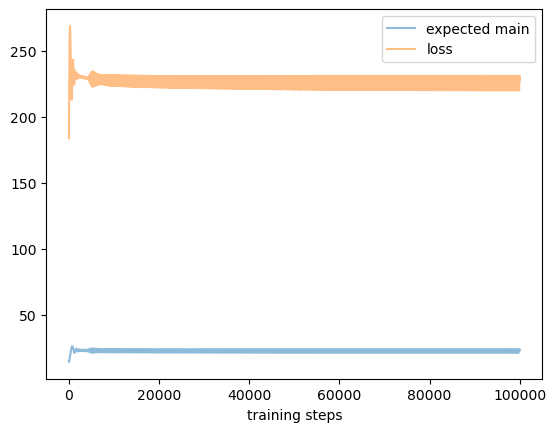

In [54]:
plt.plot(main_logs, label='expected main', alpha=0.5)
plt.plot(loss_logs, label='loss', alpha=0.5)
plt.xlabel('training steps')
plt.legend()
plt.show()

Let us check the optimization results:

In [55]:
main, constraints, _ = get_loss(log_nu, z, mu, omega)

In [56]:
min_i = tf.argmin(main)
min_i, main[min_i], [c[min_i] for c in constraints]

(<tf.Tensor: shape=(), dtype=int64, numpy=9>,
 <tf.Tensor: shape=(), dtype=float32, numpy=22.825344>,
 [<tf.Tensor: shape=(), dtype=float32, numpy=0.19493103>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([ 0.00825167,  0.10727   , -0.2302252 , -0.11251056, -0.01769245,
          0.00312483, -0.03032732, -0.08443722, -0.05649842, -0.20020565],
        dtype=float32)>])

And for checking fractal:

In [57]:
log_nu[min_i, :]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7.6524253 , 3.0127184 , 1.6610837 , 1.0255128 , 0.566224  ,
       0.39784366, 0.26623937, 0.3381066 , 0.20568936, 0.06908803],
      dtype=float32)>

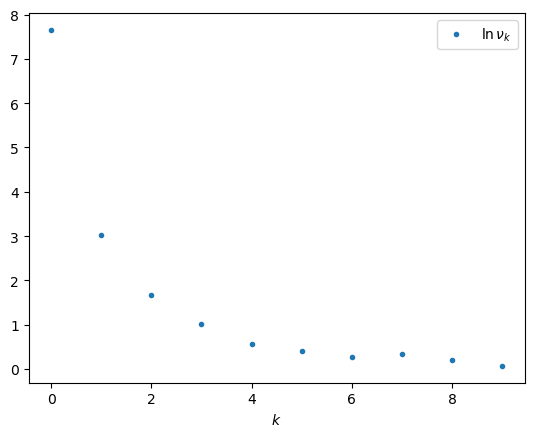

In [58]:
plt.plot(log_nu[min_i, :], '.', label='$\\ln \\nu_k$')
plt.xlabel('$k$')
plt.legend()
plt.show()

Zoom in:

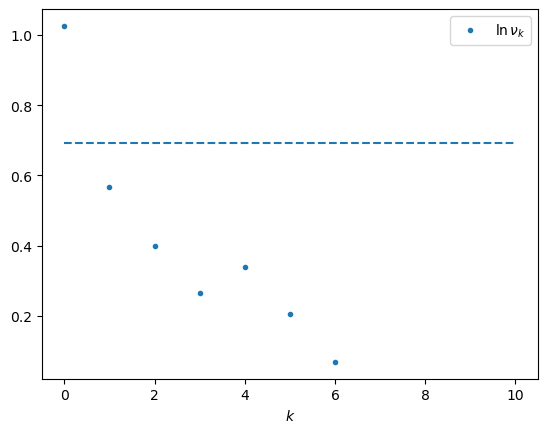

In [62]:
plt.plot(log_nu[min_i, 3:], '.', label='$\ln \\nu_k$')
plt.hlines(np.log(2), linestyle='--', xmin=0, xmax=LEVELS)
plt.xlabel('$k$')
plt.legend()
plt.show()

Apparently, the $\ln \nu_k$ are not equal, thus fractal is not satisfied. But it seems that $\ln \nu_k$ obeys a power law on $k$.